Generalising the LEP vs shower exploration to work on any two variables.

In [313]:
import logging

import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)

import numpy as np
import pandas as pd

from importlib import reload

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [314]:
from sleep_events import load_days_data

day_data = load_days_data(True)

In [315]:
[c for c in day_data.columns if 'energy' in c]

['energy']

In [316]:
col1 = 'exercise:fitbit:steps'
col2 = 'night:yasa:adjusted:deepSleepSecs'

columns_to_select = [col1, col2]

df = day_data.copy()[columns_to_select]
df.index = day_data['dayAndNightOf']
import notebooks.Util.Time as Time
reload(Time)
df = Time.convert_cols_to_hours(df)

c1 = Time.convert_col_name(col1)
c2 = Time.convert_col_name(col2)
df = df[df[c1].notna() & df[c2].notna()]
df['Diff'] = df[c2] - df[c1]


df.head()

,exercise:fitbit:steps,night:yasa:adjusted:deepSleep,Diff
dayAndNightOf,,,
2024-07-11,214.0,1.383333,-212.616667
2024-07-12,788.0,1.383333,-786.616667
2024-07-14,376.0,0.816667,-375.183333
2024-07-15,2607.0,1.050000,-2605.950000
2024-07-16,919.0,1.350000,-917.650000


# Simple correlations

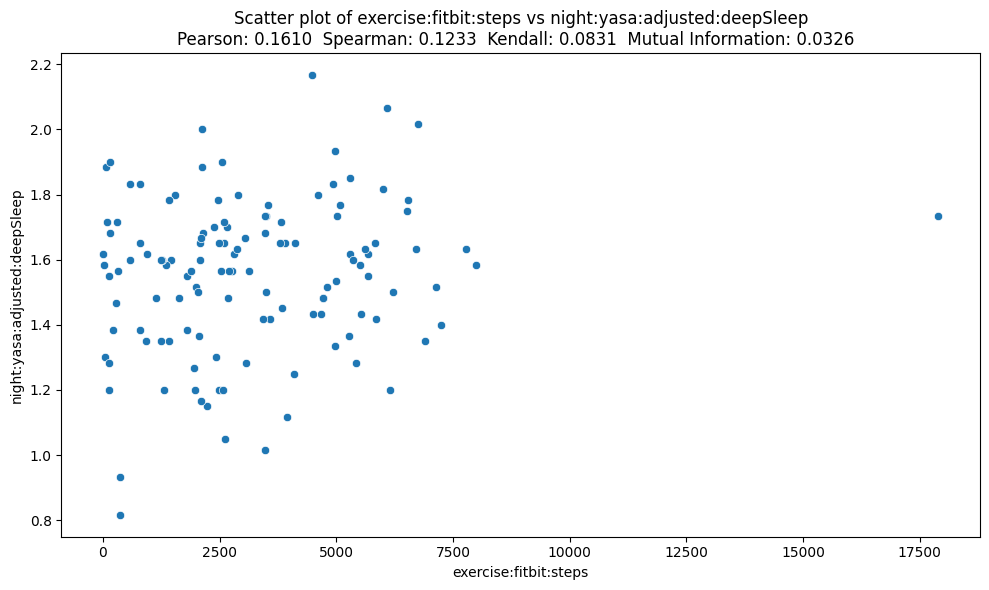

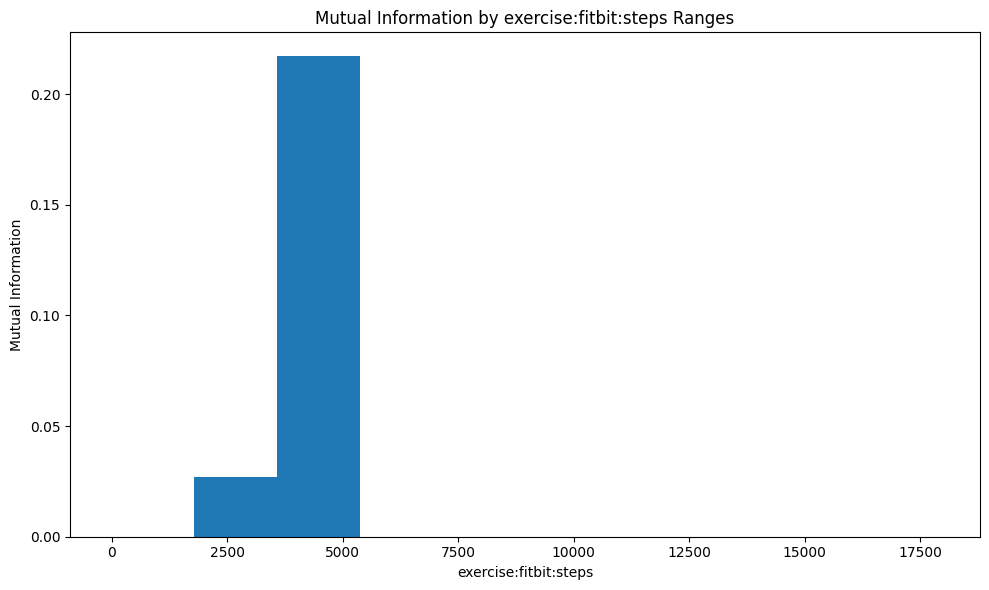

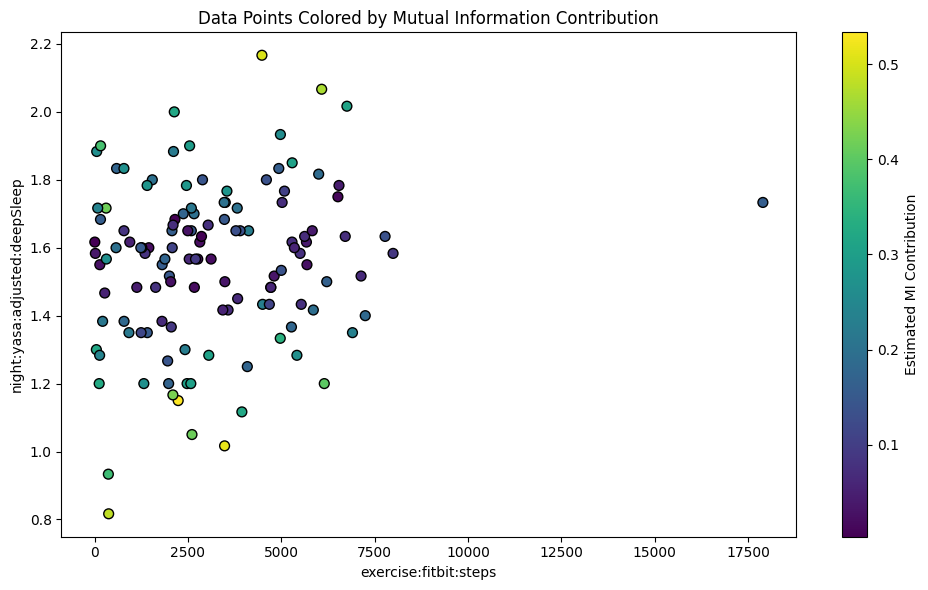

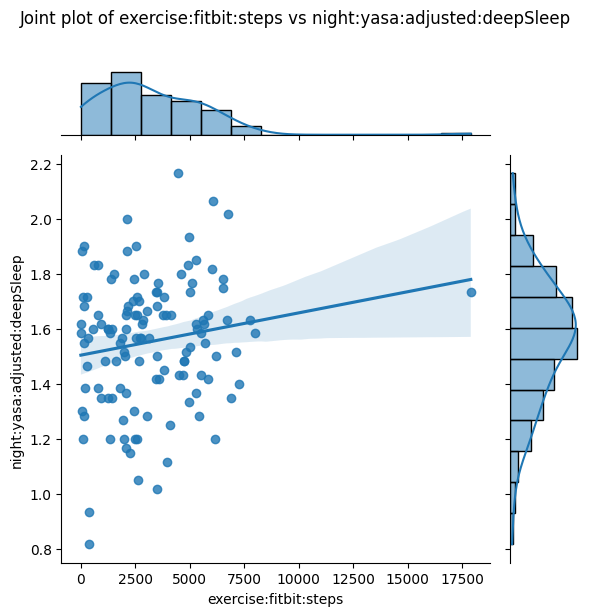

Pearson correlation: 0.1610, p-value: 0.0728
Spearman correlation: 0.1233, p-value: 0.1708
Kendall correlation: 0.0831, p-value: 0.1738
Mutual Information: 0.0326


In [317]:
import stats_two_variables
reload(stats_two_variables)

results = stats_two_variables.calculate_correlations(df, c1, c2)
stats_two_variables.visualize_scatter(df, c1, c2, results)
stats_two_variables.visualize_joint_plot(df, c1, c2)
stats_two_variables.print_correlation_results(results)

# Look for horizontal threshold where linear model works better

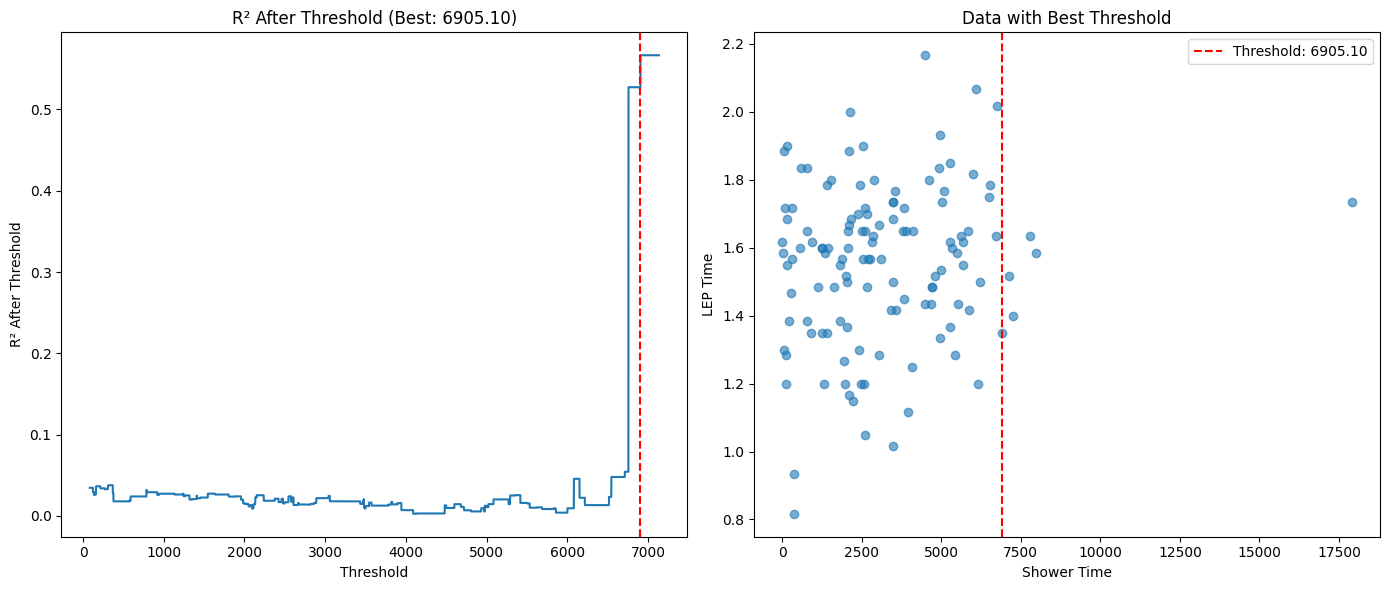

(np.float64(6905.099999999976),
        threshold  points_after  points_before  r2_after  mean_after  std_after
 0           83.1           120              5  0.034472    1.551111   0.234498
 1           83.2           120              5  0.034472    1.551111   0.234498
 2           83.3           120              5  0.034472    1.551111   0.234498
 3           83.4           120              5  0.034472    1.551111   0.234498
 4           83.5           120              5  0.034472    1.551111   0.234498
 ...          ...           ...            ...       ...         ...        ...
 70515     7134.6             5            120  0.566690    1.573333   0.111853
 70516     7134.7             5            120  0.566690    1.573333   0.111853
 70517     7134.8             5            120  0.566690    1.573333   0.111853
 70518     7134.9             5            120  0.566690    1.573333   0.111853
 70519     7135.0             5            120  0.566690    1.573333   0.111853
 
 [7052

In [318]:
import stats_two_variables
reload(stats_two_variables)

X = df[c1].values.reshape(-1, 1)
y = df[c2].values

stats_two_variables.find_optimal_threshold(X, y)

# Machine learning

Outlier removal: removed 9 points (7.2%), R² improved from 0.1386 to 0.2310
Decision Tree Rules:
|--- exercise:fitbit:steps <= 4106.50
|   |--- exercise:fitbit:steps <= 3920.00
|   |   |--- exercise:fitbit:steps <= 2098.00
|   |   |   |--- value: [1.46]
|   |   |--- exercise:fitbit:steps >  2098.00
|   |   |   |--- value: [1.57]
|   |--- exercise:fitbit:steps >  3920.00
|   |   |--- exercise:fitbit:steps <= 4016.00
|   |   |   |--- value: [1.12]
|   |   |--- exercise:fitbit:steps >  4016.00
|   |   |   |--- value: [1.25]
|--- exercise:fitbit:steps >  4106.50
|   |--- exercise:fitbit:steps <= 4489.00
|   |   |--- exercise:fitbit:steps <= 4302.00
|   |   |   |--- value: [1.65]
|   |   |--- exercise:fitbit:steps >  4302.00
|   |   |   |--- value: [2.17]
|   |--- exercise:fitbit:steps >  4489.00
|   |   |--- exercise:fitbit:steps <= 4870.00
|   |   |   |--- value: [1.53]
|   |   |--- exercise:fitbit:steps >  4870.00
|   |   |   |--- value: [1.66]

Using 2D GMM clustering on both exercise:f

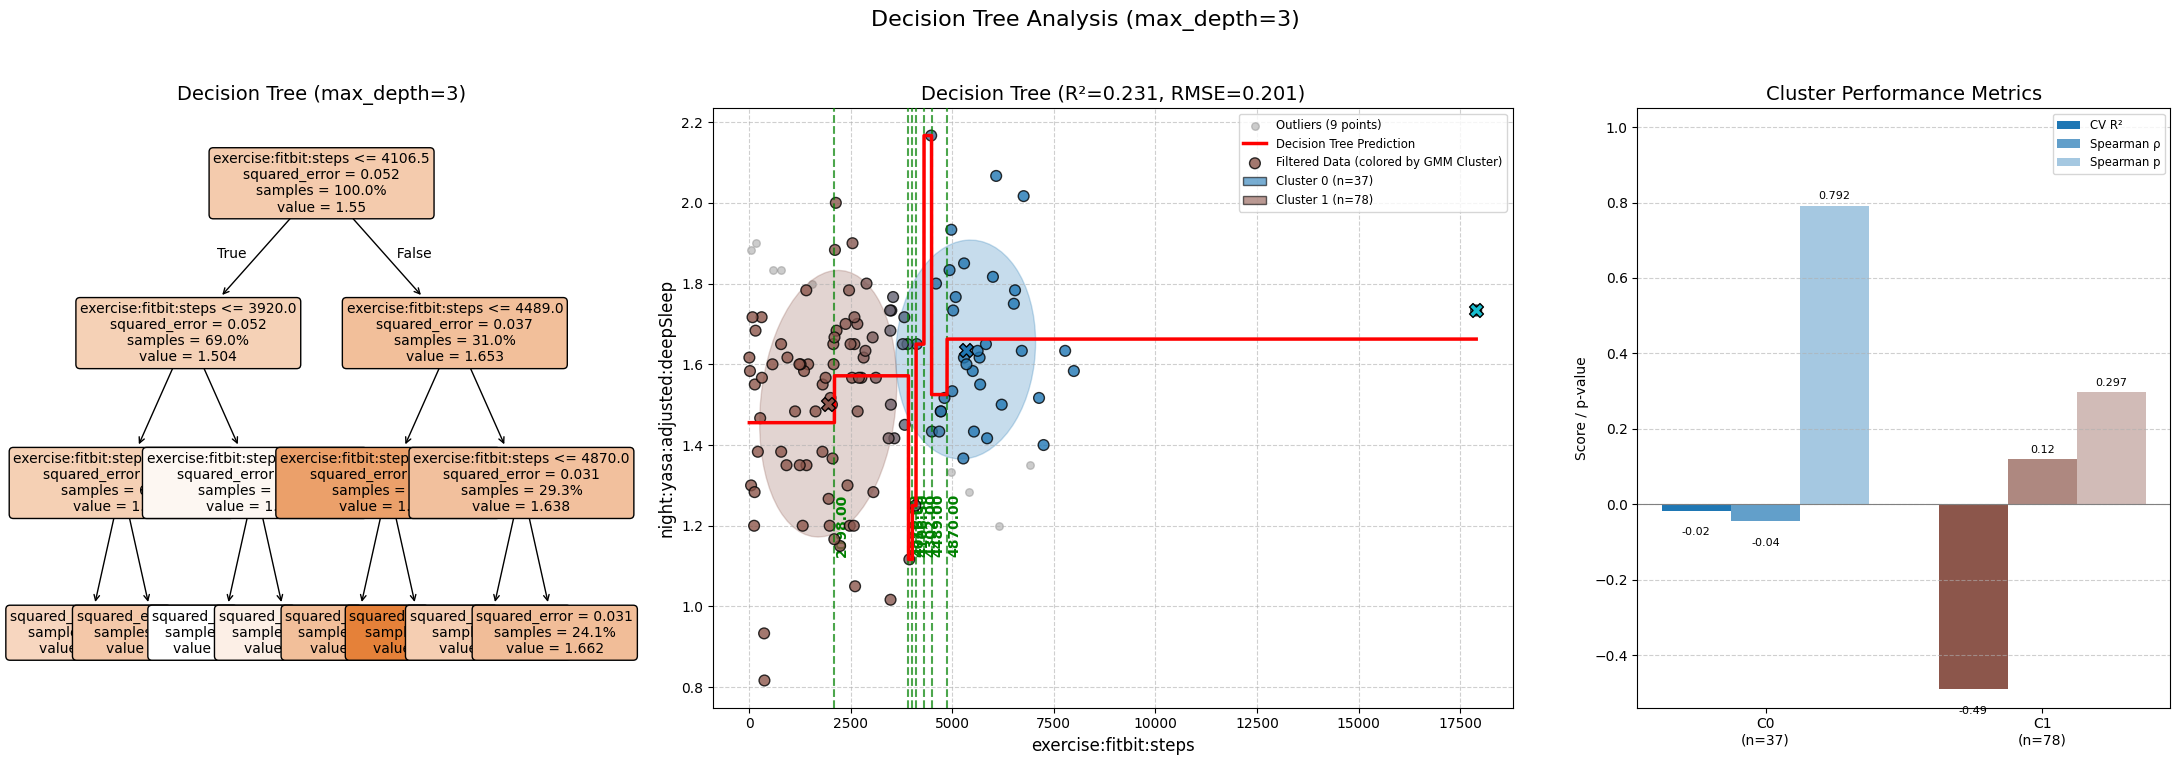

Decision Tree Regression Results:
R² score: 0.2310
RMSE: 0.2006
Outliers removed: 9 points (7.2%)


In [319]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_decision_tree_regressor(df, c1, c2, max_depth=3)

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages

Outlier removal: removed 9 points (7.2%), R² improved from 0.0263 to 0.9900
Best Gaussian Process Kernel: RBF (ls=0.1)
Optimized kernel parameters: 0.949**2 * RBF(length_scale=1e-05)
Using 2D GMM clustering on both exercise:fitbit:steps and night:yasa:adjusted:deepSleep
Finding GMM subsets for Gaussian Process (RBF (ls=0.1))...

--- Gaussian Process (RBF (ls=0.1)) Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 38 points
    exercise:fitbit:steps range: 3819.00 to 7992.00 (std=983.53)
    night:yasa:adjusted:deepSleep range: 1.25 to 2.17 (std=0.20)
    CV R² Score: -0.1255 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): 0.1171
    Spearman p-value: 0.4839
    Mutual Information: 0.1131
  GMM - Cluster 1 (Index 1):
    Size: 77 points
    exercise:fitbit:steps range: 5.00 to 3943.00 (std=1121.72)
    night:yasa:adjusted:deepSleep range: 0.82 to 1.90 (std=0.23)
    CV R² Score: -0.0199 (Note: Negative R²

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


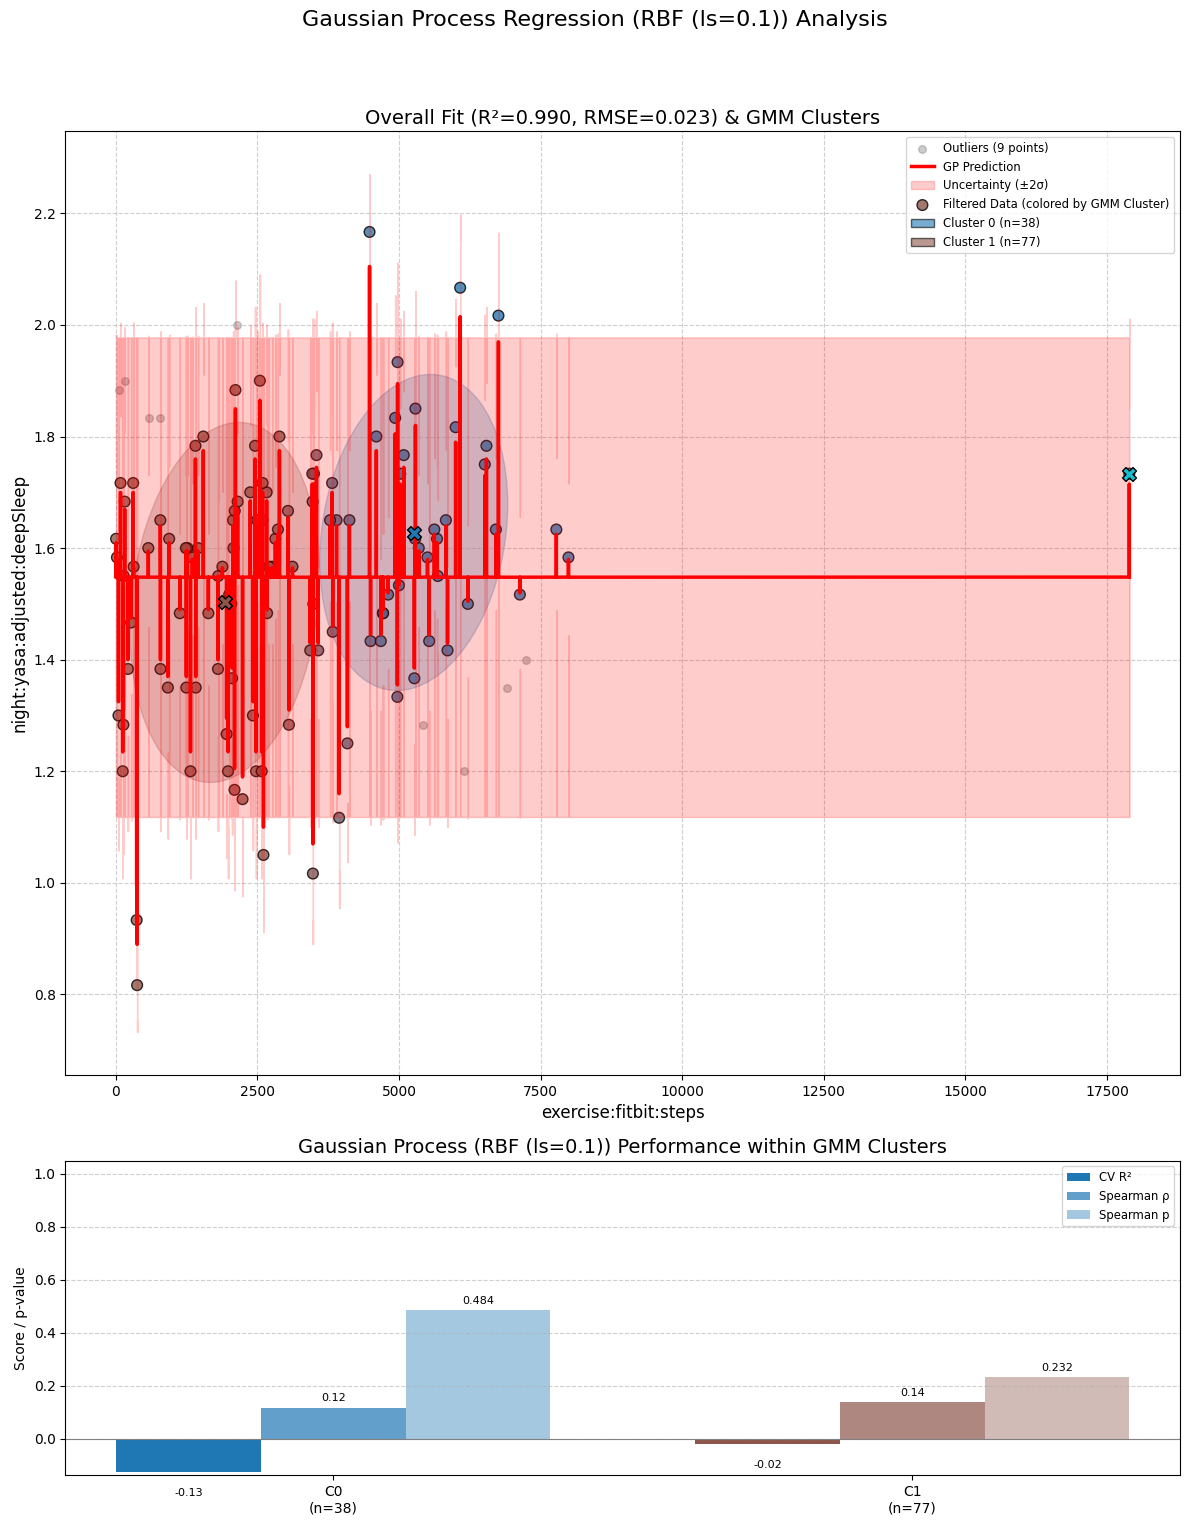


Gaussian Process Regression Results (Kernel: RBF (ls=0.1)):
R² score: 0.9900
RMSE: 0.0227
Outliers removed: 9 points (7.2%)
Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [328]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_gaussian_process_regressor(df, c1, c2)

Outlier removal: removed 12 points (9.6%), R² improved from 0.0214 to 0.0980
Using 2D GMM clustering on both exercise:fitbit:steps and night:yasa:adjusted:deepSleep
Finding GMM subsets for SVR (rbf, C=1.0)...

--- SVR (rbf, C=1.0) Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 36 points
    exercise:fitbit:steps range: 3783.00 to 7992.00 (std=1062.95)
    night:yasa:adjusted:deepSleep range: 1.33 to 2.17 (std=0.19)
    CV R² Score: -0.4399 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): -0.0108
    Spearman p-value: 0.9500
    Mutual Information: 0.3026
  GMM - Cluster 1 (Index 1):
    Size: 76 points
    exercise:fitbit:steps range: 5.00 to 4089.00 (std=1115.95)
    night:yasa:adjusted:deepSleep range: 0.82 to 2.00 (std=0.23)
    CV R² Score: -0.1077 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): 0.0357
    Spearman p-value: 0.7592
    Mutual

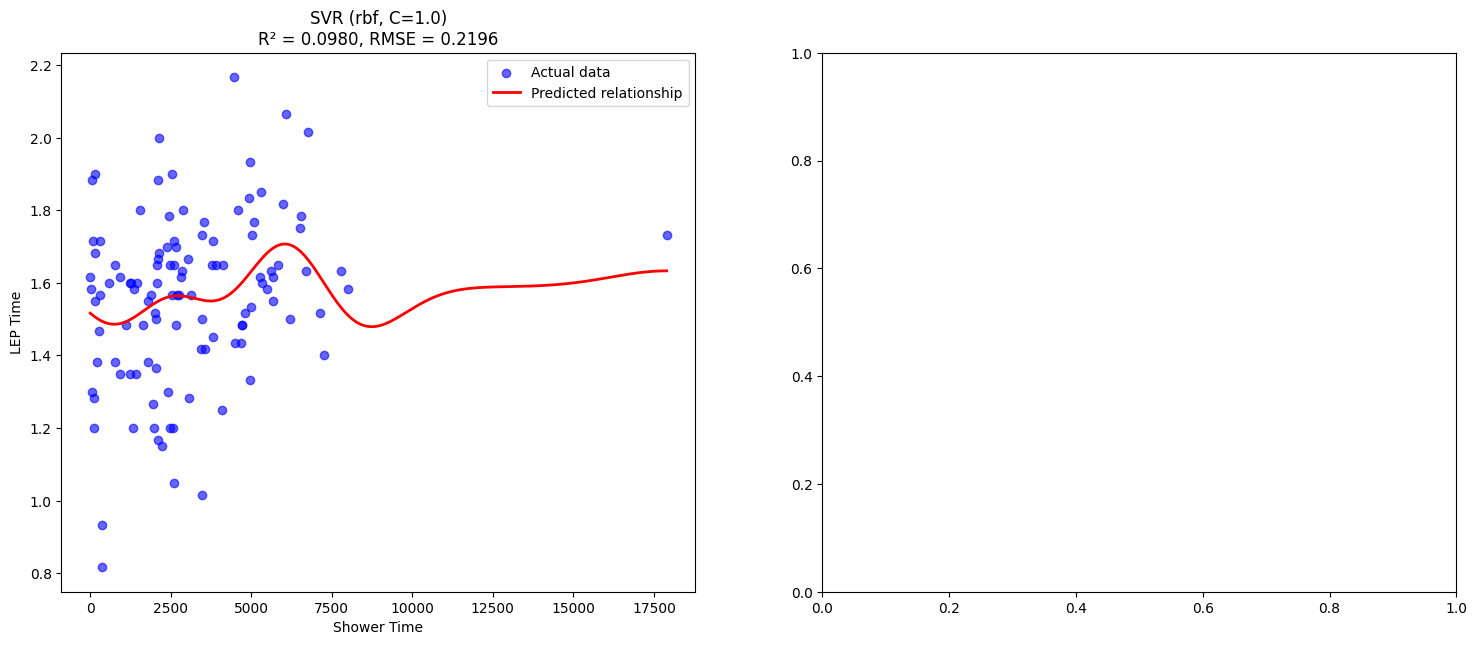

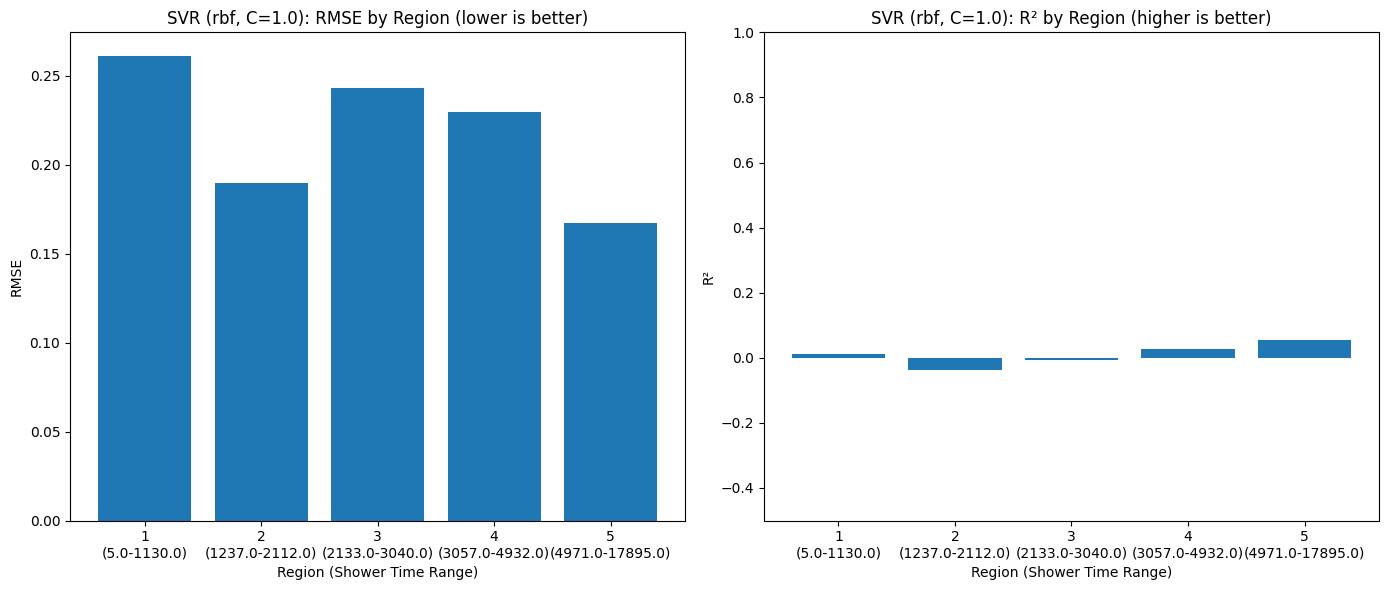

<Figure size 640x480 with 0 Axes>


SVR Final Results (Best params: kernel=rbf, C=1.0):
Overall R² (on filtered data): 0.0980
Overall RMSE (on filtered data): 0.2196
Outliers removed: 12 points (9.6%)

Per-Cluster Model Performance:
  Cluster 0 (size: 36): R²=-0.4399, RMSE=0.1851
  Cluster 1 (size: 76): R²=-0.1077, RMSE=0.2344


In [321]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_svr(df, c1, c2)

Using 2D GMM clustering on both exercise:fitbit:steps and night:yasa:adjusted:deepSleep
Finding GMM subsets for k-NN Regressor (k=3)...

--- k-NN Regressor (k=3) Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 81 points
    exercise:fitbit:steps range: 5.00 to 3943.00 (std=1123.97)
    night:yasa:adjusted:deepSleep range: 0.82 to 2.00 (std=0.24)
    CV R² Score: -0.3938 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): 0.0176
    Spearman p-value: 0.8762
    Mutual Information: 0.0000
  GMM - Cluster 1 (Index 1):
    Size: 43 points
    exercise:fitbit:steps range: 3783.00 to 7992.00 (std=1025.98)
    night:yasa:adjusted:deepSleep range: 1.20 to 2.17 (std=0.21)
    CV R² Score: -0.5878 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): -0.0611
    Spearman p-value: 0.6969
    Mutual Information: 0.1727
Skipping GMM cluster 2 due to insufficient data 

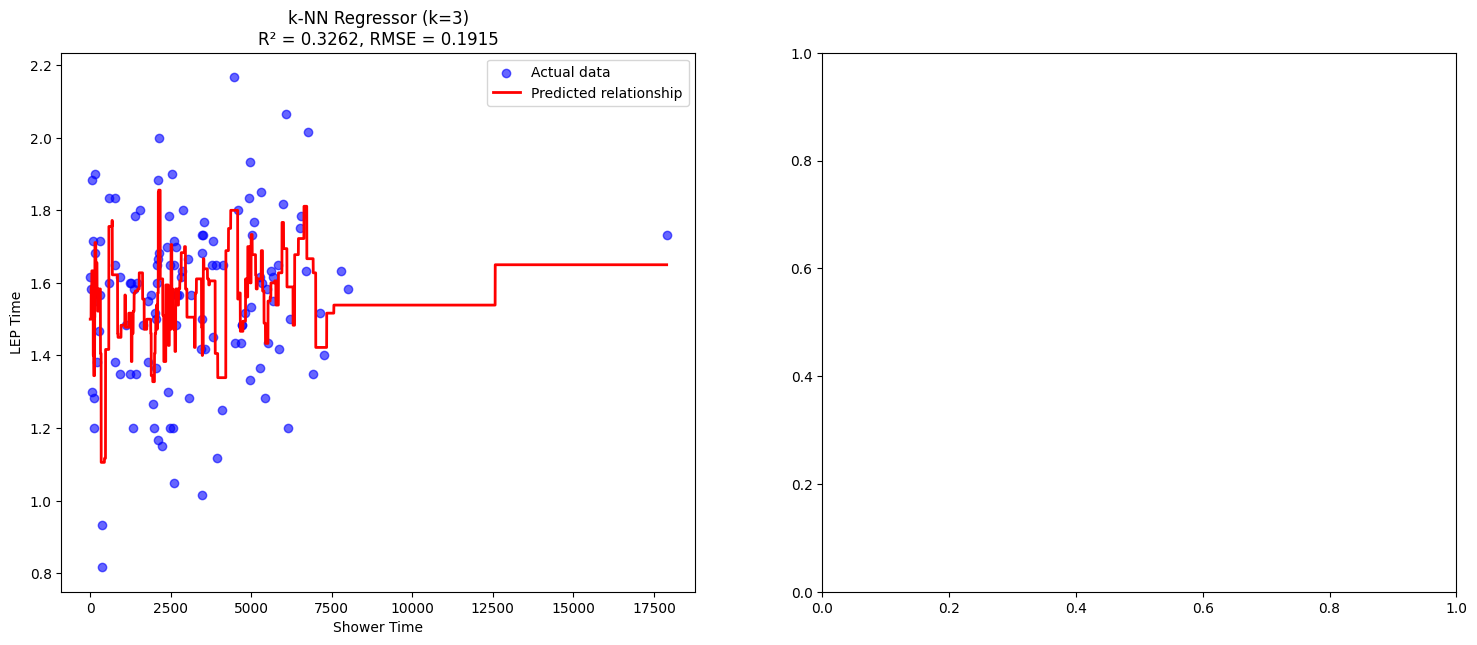

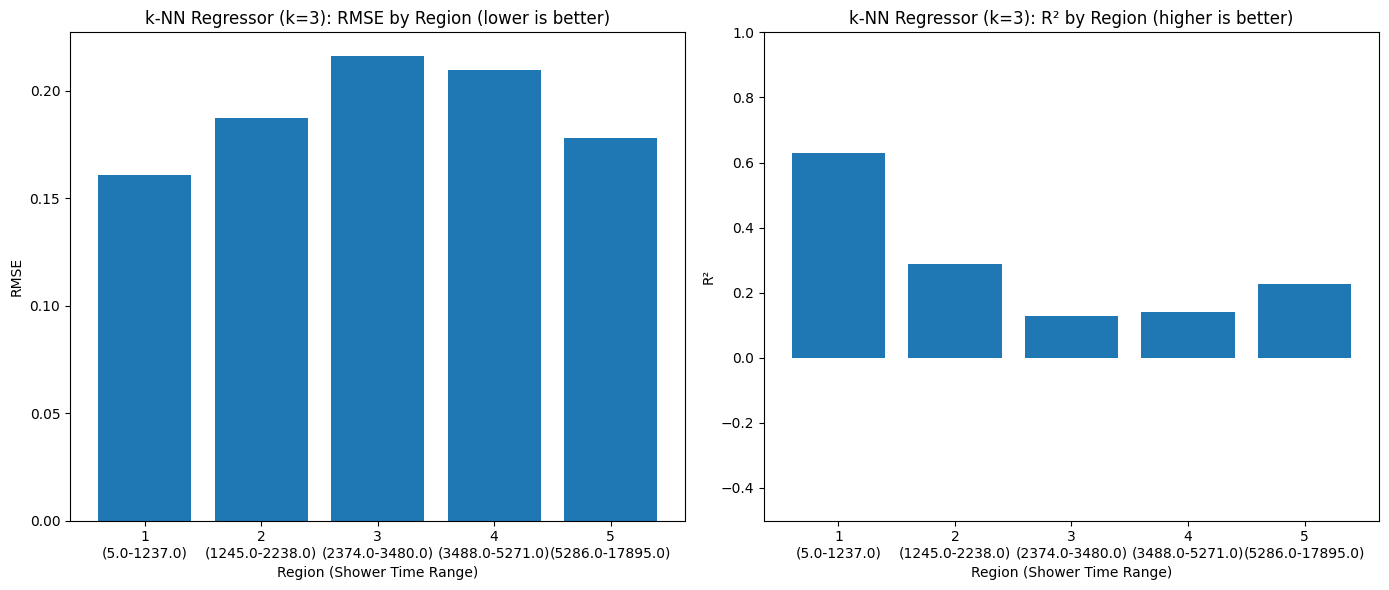

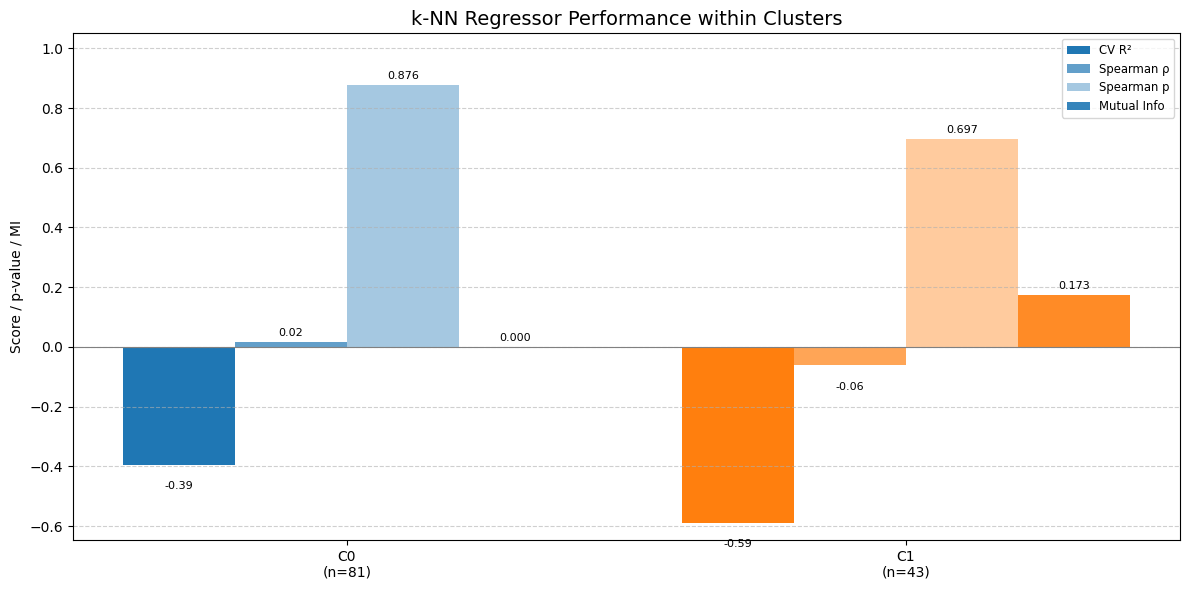

<Figure size 640x480 with 0 Axes>

k-NN Regression Results (k=3):
R² score: 0.3262
RMSE: 0.1915

Per-Cluster Model Performance:
  Cluster 0 (size: 81): R²=-0.3938, RMSE=0.2387, MI=0.0000
  Cluster 1 (size: 43): R²=-0.5878, RMSE=0.2124, MI=0.1727


In [322]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_knn_regressor(df, c1, c2)




Random Forest Feature Importance: 1.0000
Using 2D GMM clustering on both exercise:fitbit:steps and night:yasa:adjusted:deepSleep
Finding GMM subsets for Random Forest (n=50, depth=5)...

--- Random Forest (n=50, depth=5) Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 81 points
    exercise:fitbit:steps range: 5.00 to 3943.00 (std=1123.97)
    night:yasa:adjusted:deepSleep range: 0.82 to 2.00 (std=0.24)
    CV R² Score: -0.3453 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): 0.0176
    Spearman p-value: 0.8762
    Mutual Information: 0.0000
  GMM - Cluster 1 (Index 1):
    Size: 43 points
    exercise:fitbit:steps range: 3783.00 to 7992.00 (std=1025.98)
    night:yasa:adjusted:deepSleep range: 1.20 to 2.17 (std=0.21)
    CV R² Score: -0.7177 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): -0.0611
    Spearman p-value: 0.6969
    Mutual Informati

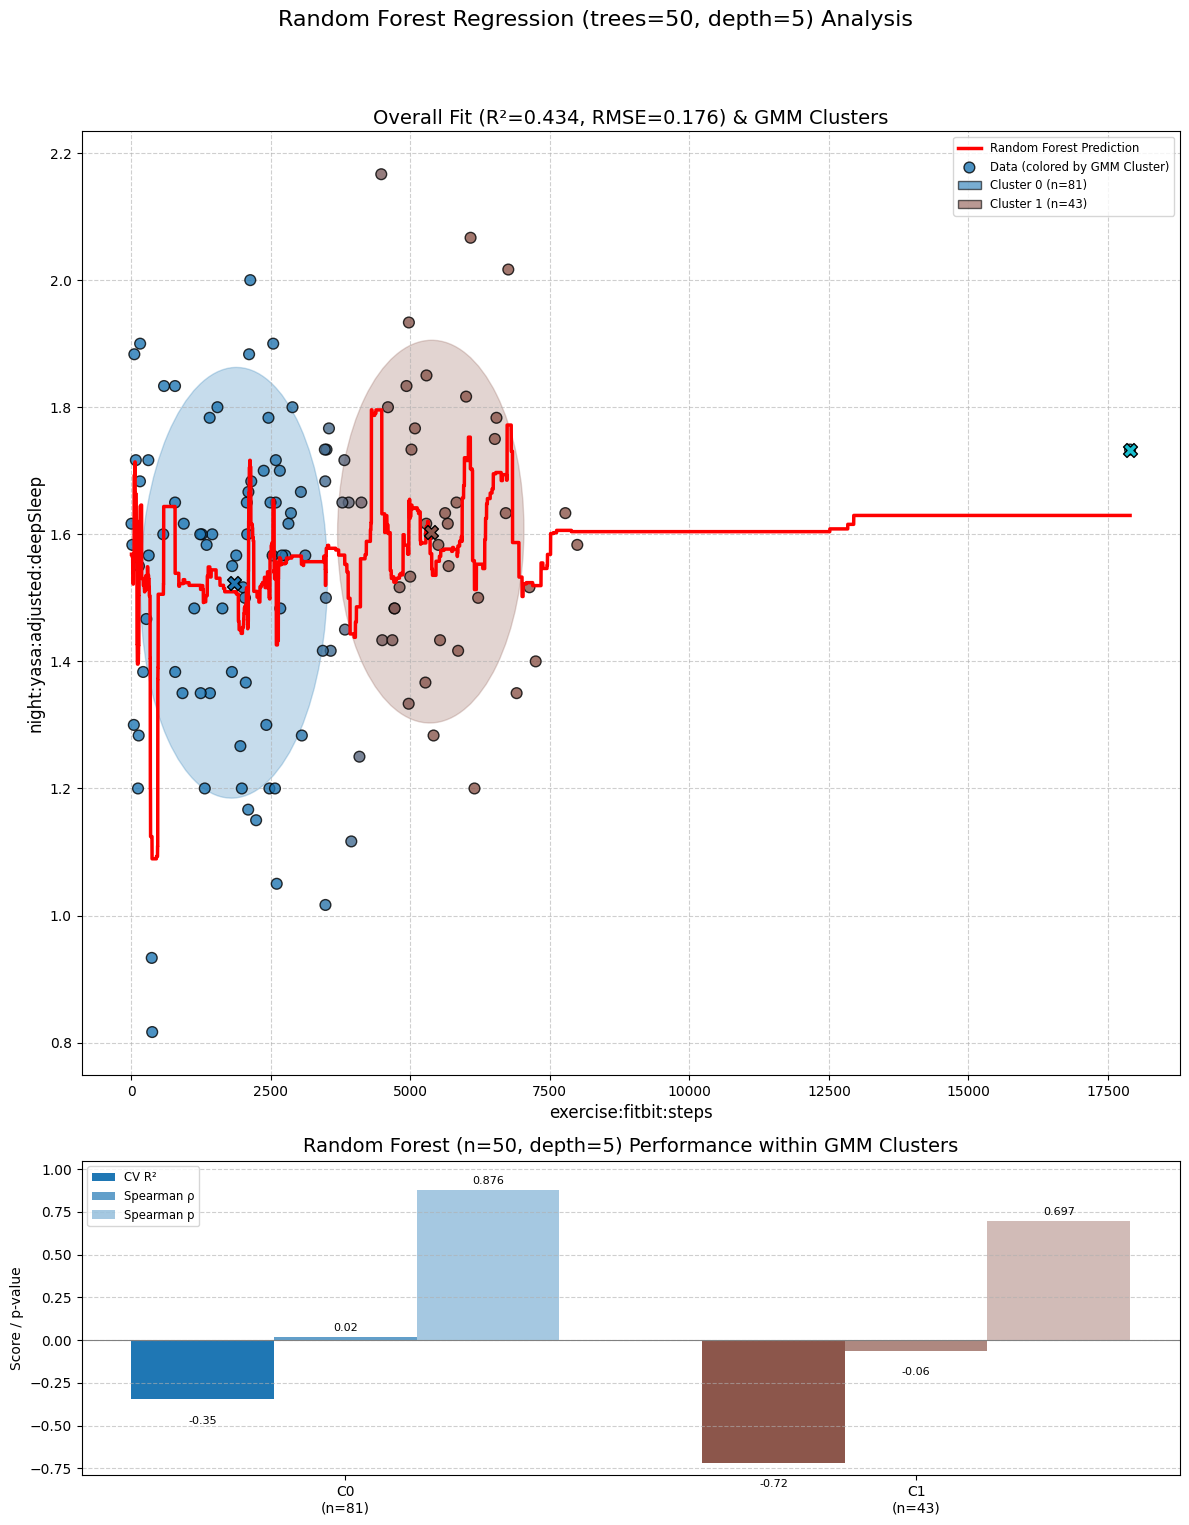

Random Forest Regression Results (trees=50, depth=5):
R² score: 0.4336
RMSE: 0.1756


In [323]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_random_forest_regressor(df, c1, c2)


# Linear 

Outlier removal: removed 12 points (9.6%), R² improved from 0.0259 to 0.1057
Using 2D GMM clustering on both exercise:fitbit:steps and night:yasa:adjusted:deepSleep
Finding GMM subsets for Linear Regression...

--- Linear Regression Performance within GMM Clusters ---
  GMM - Cluster 0 (Index 0):
    Size: 45 points
    exercise:fitbit:steps range: 3476.00 to 7992.00 (std=1126.48)
    night:yasa:adjusted:deepSleep range: 1.25 to 2.17 (std=0.19)
    CV R² Score: -0.1750 (Note: Negative R² indicates model performs worse than predicting the mean)
    Spearman Correlation (ρ): 0.1033
    Spearman p-value: 0.4997
    Mutual Information: 0.1270
  GMM - Cluster 1 (Index 1):
    Size: 67 points
    exercise:fitbit:steps range: 5.00 to 3480.00 (std=987.38)
    night:yasa:adjusted:deepSleep range: 0.82 to 1.90 (std=0.23)
    CV R² Score: 0.0133
    Spearman Correlation (ρ): 0.1963
    Spearman p-value: 0.1114
    Mutual Information: 0.0000
Skipping GMM cluster 2 due to insufficient data points (

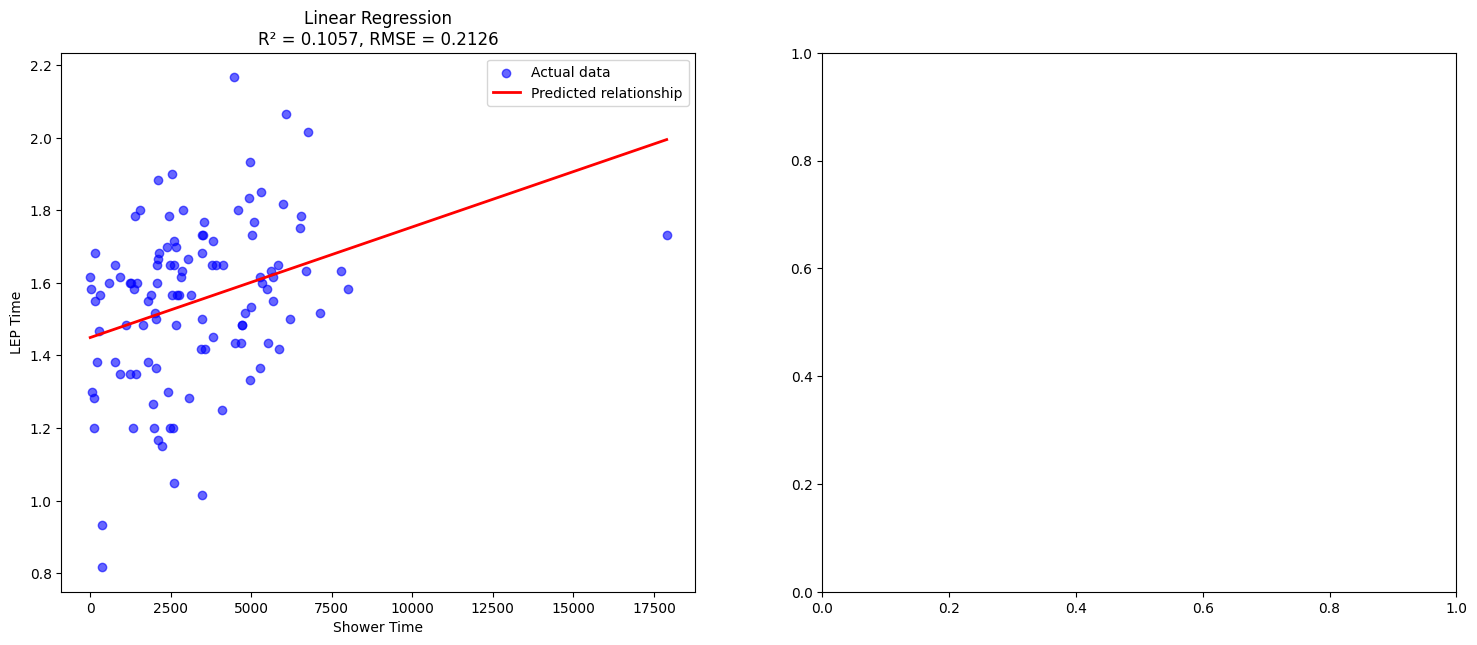

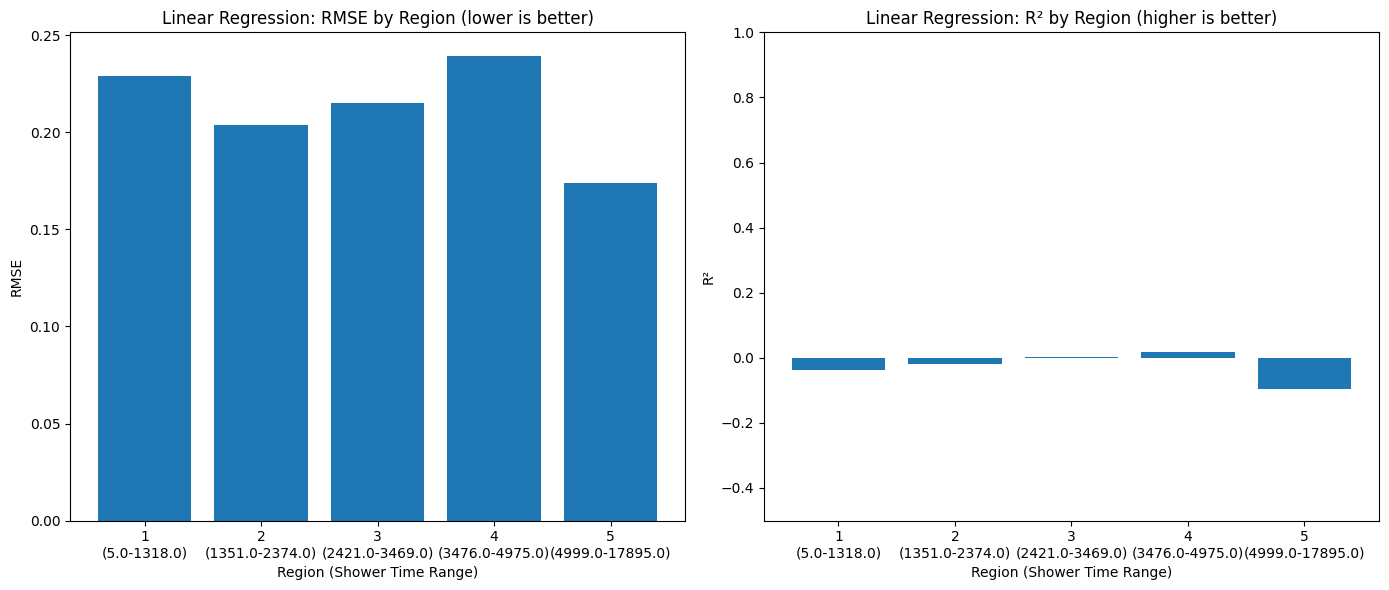

<Figure size 640x480 with 0 Axes>

Linear Regression Performance:
R²: 0.1057
MAE: 0.1696
RMSE: 0.2126

Per-Cluster Model Performance:
  Cluster 0 (size: 45): R²=-0.1750, RMSE=0.1913
  Cluster 1 (size: 67): R²=0.0133, RMSE=0.2257


In [324]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_linear_regression(df, c1, c2)




# Symbolic representation

In [325]:
from pysr import PySRRegressor

df2 = df.copy().drop(columns=['Diff'])
X = df2.drop(columns=[c2])
y = df2[c2]
X.columns = X.columns.str.replace(':', '_')
y.name = y.name.replace(':', '_')

model = PySRRegressor(niterations=30, progress=True)
model.fit(X, y)


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick         score  \
	0         0.000000e+00   
	1   >>>>  6.567627e-03   
	2         1.166858e-04   
	3         7.946603e-05   
	4         1.381219e-03   
	5         2.316188e-04   
	6         5.883491e-05   
	7         2.466690e-04   
	8         1.995433e-05   
	9         1.515309e-07   
	10        1.278917e-04   
	11        7.201455e-06   
	12        1.206267e-05   
	
	                                                                                                                                                                                                                                                                                                               equation  \
	0                                                                                                                                                                                                                                                                                                              1.553854   
	1                                                                                                                                                                                                                                                                    (exercise_fitbit_steps * 1.5392054e-5) + 1.5043564   
	2                                                                                                                                                                                                                                           exercise_fitbit_steps + ((exercise_fitbit_steps + -1.504196) * -0.99998456)   
	3                                                                                                                                                                                                                     ((exercise_fitbit_steps * -1.999985) + 1.50556) + (exercise_fitbit_steps + exercise_fitbit_steps)   
	4                                                                                                                                                                                                 (exercise_fitbit_steps + ((exercise_fitbit_steps * -0.9999835) - -1.4987909)) - (-0.71440727 / exercise_fitbit_steps)   
	5                                                                                                                                                                                      (exercise_fitbit_steps + ((exercise_fitbit_steps * -0.99998283) + 1.4958558)) + (1.3005881 / (exercise_fitbit_steps + 3.237751))   
	6                                                                                                                                                                     ((exercise_fitbit_steps * -0.99998164) + ((0.21695597 / ((exercise_fitbit_steps * 0.07298842) + 1.6711271)) + exercise_fitbit_steps)) + 1.4926144   
	7                                                                                                                                     (exercise_fitbit_steps + ((((exercise_fitbit_steps - 3.624978) / exercise_fitbit_steps) / (exercise_fitbit_steps * 0.4468094)) + (exercise_fitbit_steps * -0.999983))) + 1.495173   
	8                                                                                                                     ((exercise_fitbit_steps + (((exercise_fitbit_steps - 3.624978) / (0.91390556 * exercise_fitbit_steps)) / (exercise_fitbit_steps * 0.49648327))) + (exercise_fitbit_steps * -0.999983)) + 1.495173   
	9                                                                                                      ((exercise_fitbit_steps + (((exercise_fitbit_steps - 3.624978) / (0.91390556 * (exercise_fitbit_steps + 0.03327819))) / (exercise_fitbit_steps * 0.49648327))) + (exercise_fitbit_steps * -0.999983)) + 1.495173   
	10                                   (exercise_fitbit_steps + ((exercise_fitbit_steps * (exercise_fitbit_steps * (

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [326]:
import pandas as pd

equation_df = model.equations_
print(equation_df[['equation', 'loss', 'complexity']])


                                                                                                                                                                                                                                                                                                               equation  \
0                                                                                                                                                                                                                                                                                                              1.553854   
1                                                                                                                                                                                                                                                                    (exercise_fitbit_steps * 1.5392054e-5) + 1.5043564   
2                                                      

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

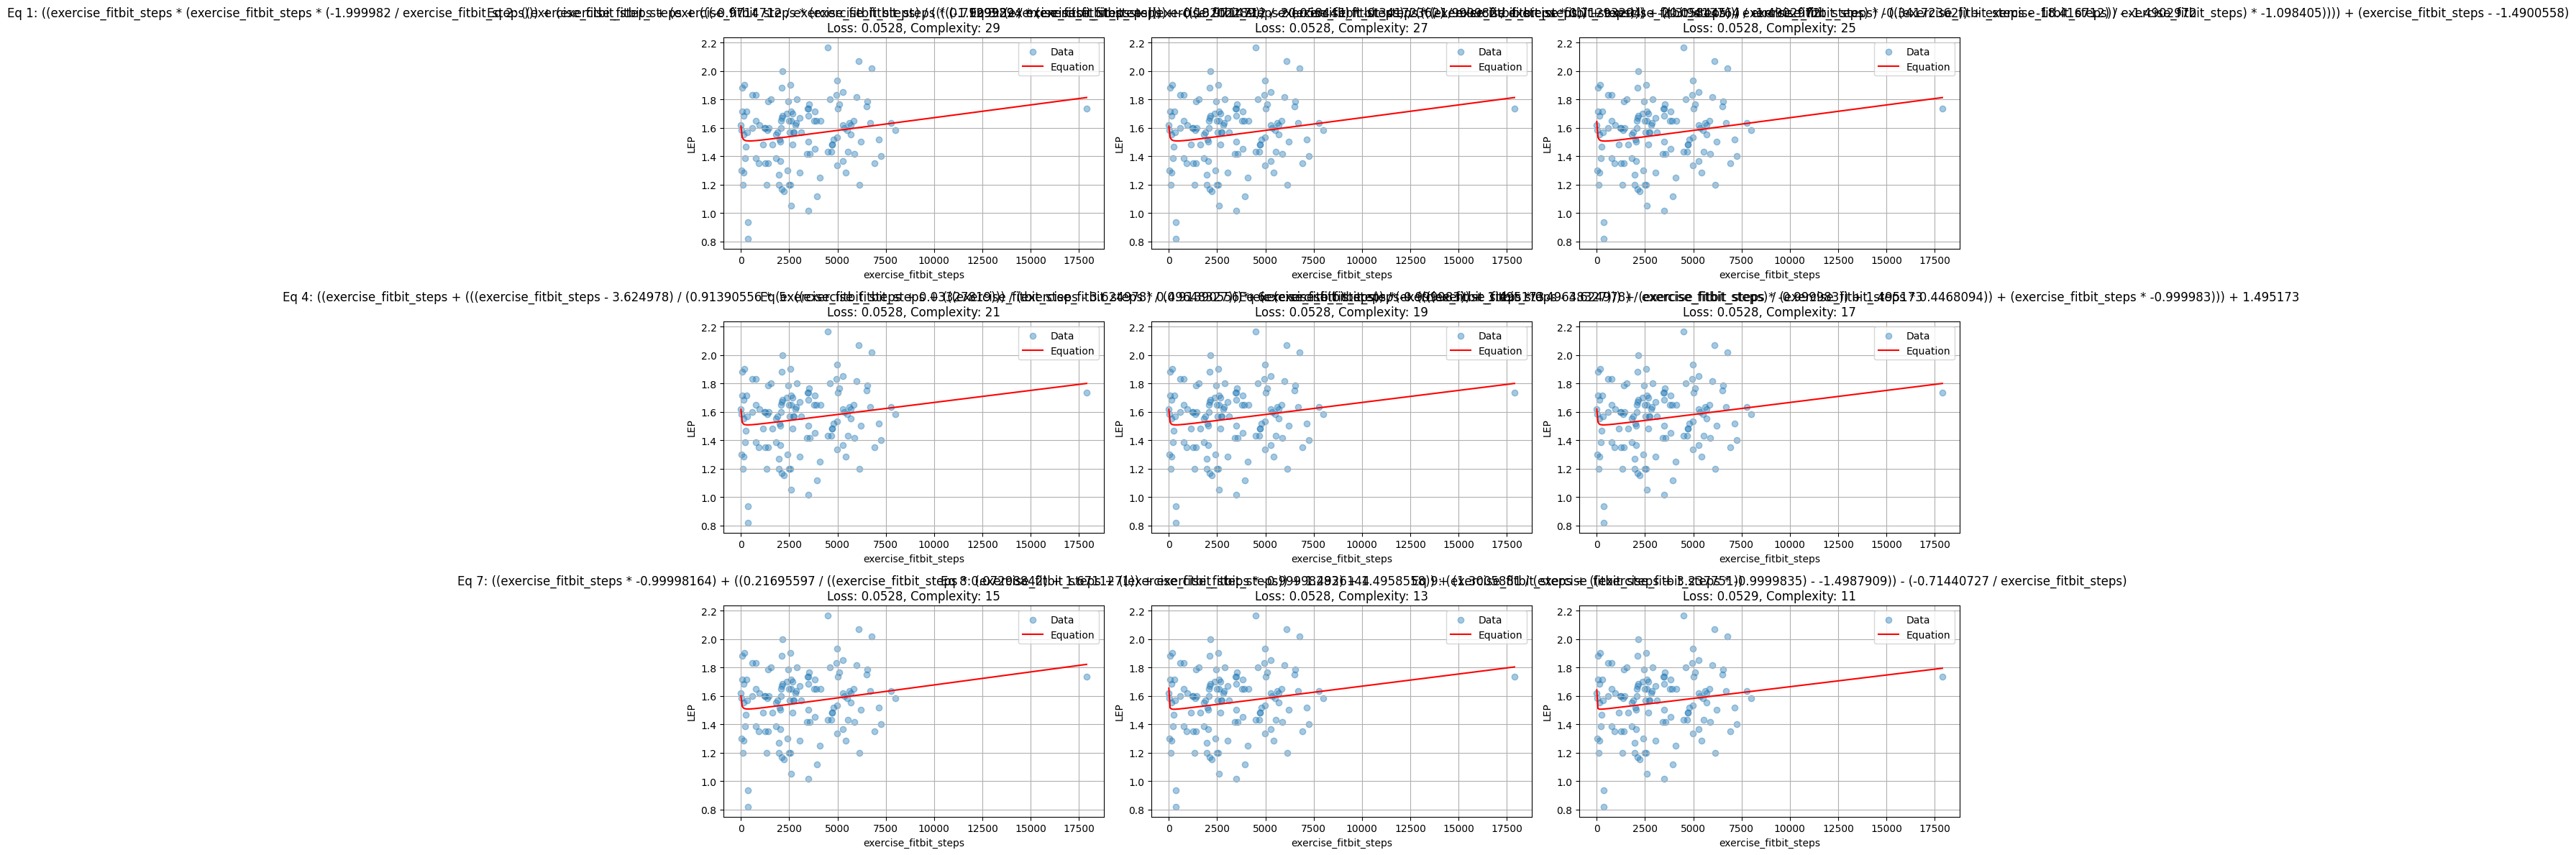

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [327]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
from sympy.utilities.lambdify import lambdify

# Define your feature
feature = X.columns[0]
x_vals = np.linspace(X[feature].min(), X[feature].max(), 300)
x_df = pd.DataFrame({feature: x_vals})

# Define output y range to clip
Y_CLIP_MIN, Y_CLIP_MAX = y.min() - 1, y.max() + 1

# Top 9 equations
top_equations = model.equations_.sort_values("loss").head(9)

x_sym = sp.Symbol(feature)

plt.figure(figsize=(18, 12))
for i, row in enumerate(top_equations.itertuples(), 1):
    try:
        expr = sp.sympify(row.equation)
        func = lambdify(x_sym, expr, modules=["numpy"])
        y_vals = func(x_vals)

        # Handle crazy outputs
        y_vals = np.nan_to_num(y_vals, nan=np.nan, posinf=np.nan, neginf=np.nan)
        y_vals = np.clip(y_vals, Y_CLIP_MIN, Y_CLIP_MAX)

        plt.subplot(3, 3, i)
        plt.scatter(X[feature], y, alpha=0.4, label="Data")
        plt.plot(x_vals, y_vals, color='red', label="Equation")
        plt.title(f"Eq {i}: {row.equation}\nLoss: {row.loss:.4f}, Complexity: {row.complexity}")
        plt.xlabel(feature)
        plt.ylabel("LEP")
        plt.legend()
        plt.grid(True)

    except Exception as e:
        print(f"⚠️ Skipped equation {i} due to error:\n{row.equation}\n{e}")

plt.tight_layout()
plt.show()


# Neural nets

In [331]:
!pip install torch


  Using cached torch-2.6.0-cp313-cp313-win_amd64.whl.metadata (28 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached torch-2.6.0-cp313-cp313-win_amd64.whl (204.1 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

Epoch [100/500], Loss: 0.973273
Epoch [200/500], Loss: 0.972607
Epoch [300/500], Loss: 0.972499
Epoch [400/500], Loss: 0.972406
Epoch [500/500], Loss: 0.972341
Epoch [100/500], Loss: 0.974131
Epoch [200/500], Loss: 0.973790
Epoch [300/500], Loss: 0.972498
Epoch [400/500], Loss: 0.972490
Epoch [500/500], Loss: 0.972494
Epoch [100/500], Loss: 0.975586
Epoch [200/500], Loss: 0.973638
Epoch [300/500], Loss: 0.972858
Epoch [400/500], Loss: 0.971810
Epoch [500/500], Loss: 0.971241
Epoch [100/500], Loss: 0.977536
Epoch [200/500], Loss: 0.977257
Epoch [300/500], Loss: 0.976935
Epoch [400/500], Loss: 0.976598
Epoch [500/500], Loss: 0.976257
Epoch [100/500], Loss: 0.973965
Epoch [200/500], Loss: 0.973005
Epoch [300/500], Loss: 0.972955
Epoch [400/500], Loss: 0.972941
Epoch [500/500], Loss: 0.972929
Epoch [100/500], Loss: 0.974808
Epoch [200/500], Loss: 0.973552
Epoch [300/500], Loss: 0.972130
Epoch [400/500], Loss: 0.970323
Epoch [500/500], Loss: 0.968905
Epoch [100/500], Loss: 0.969799
Epoch [2

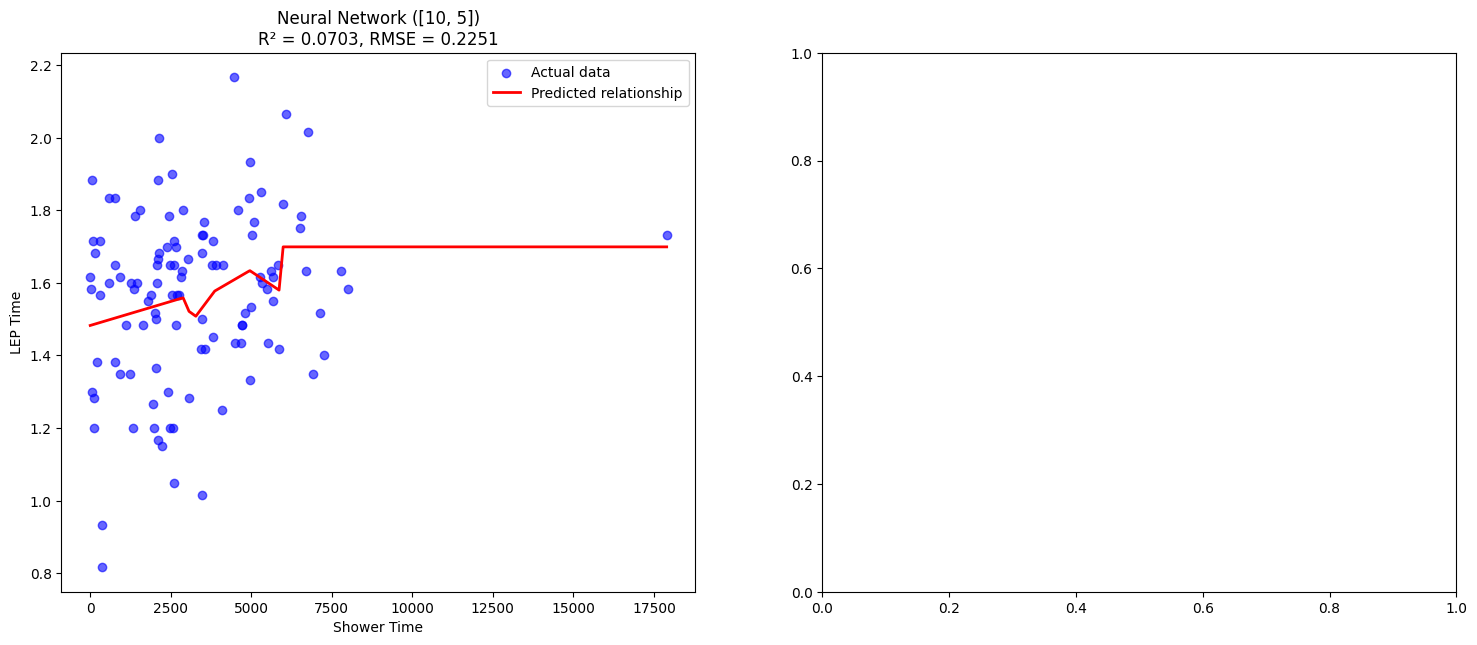

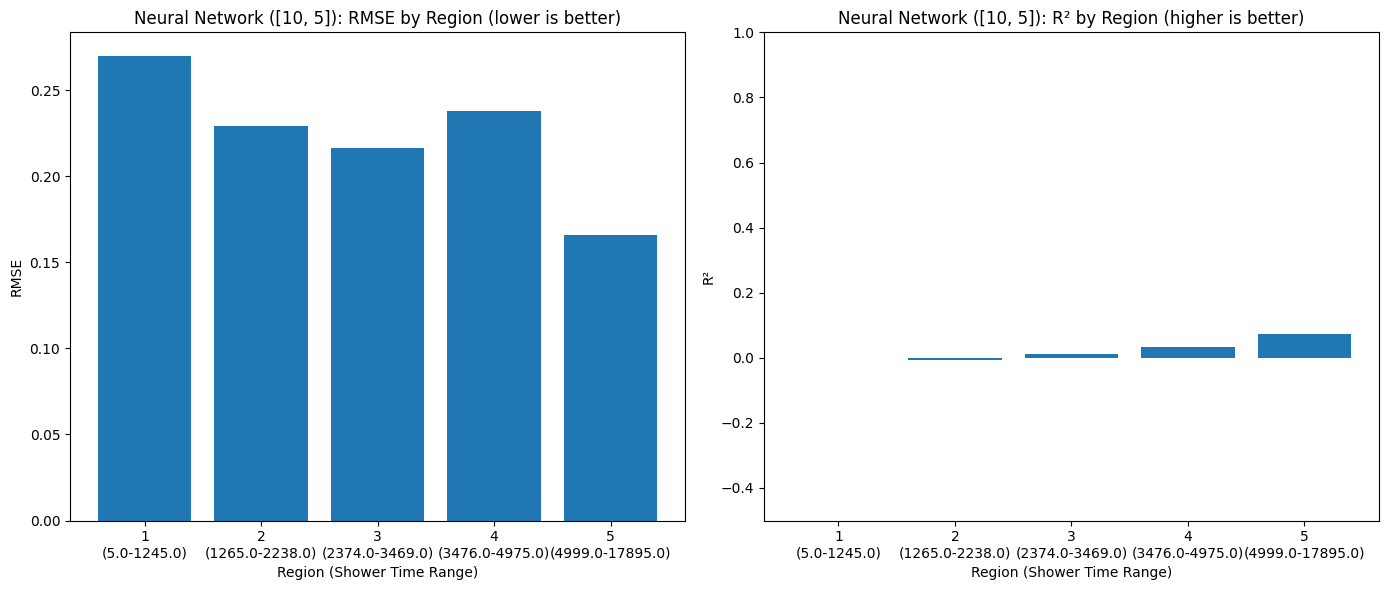

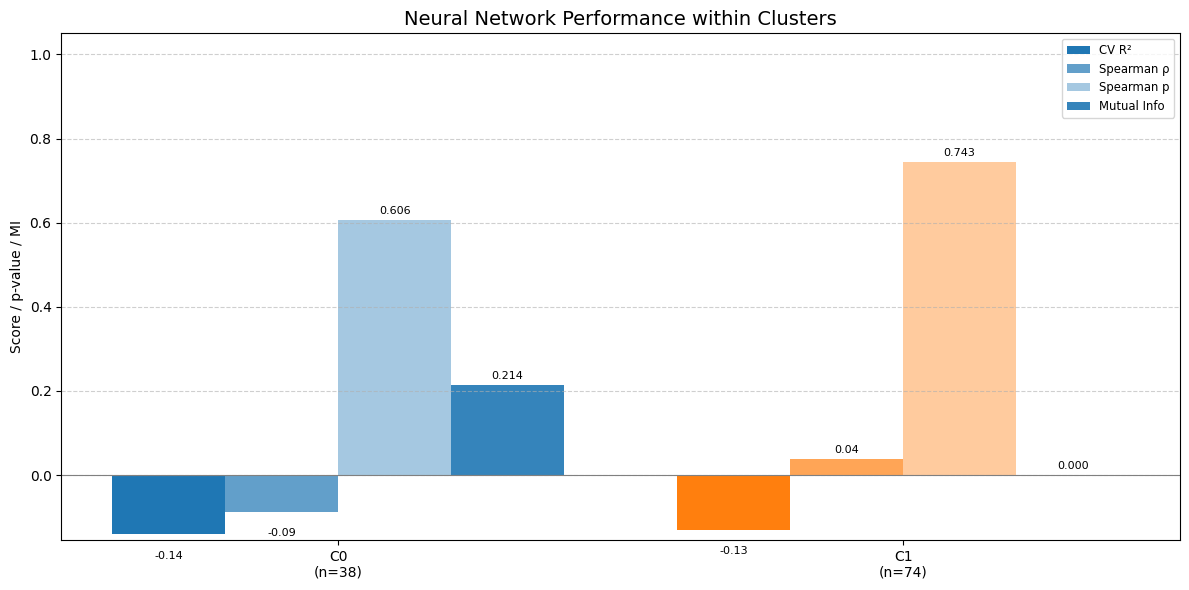

<Figure size 640x480 with 0 Axes>

Neural Network ([10, 5]) Results:
R² score: 0.0703
RMSE: 0.2251

Per-Cluster Model Performance:
  Cluster 0 (size: 38): R²=-0.1403, RMSE=0.1926, MI=0.2139
  Cluster 1 (size: 74): R²=-0.1299, RMSE=0.2417, MI=0.0000
Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data

In [332]:
import stats_two_variables
reload(stats_two_variables)

models = stats_two_variables.fit_pytorch_neural_net(df, c1, c2)

In [334]:
import stats_two_variables
reload(stats_two_variables)

X = df[[c1]].values
y = df[c2].values

models = stats_two_variables.detect_outliers(X, y, model_factory=lambda X, y: LinearRegression().fit(X, y))

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data